In [87]:
import json
import os
import pandas as pd

from config import settings

In [160]:
llm_model = "gpt-4.1-mini-2025-04-14"
llm_model = "gpt-4.1-nano-2025-04-14"

split = "train"
# split = "dev"
# split = "test"

request_dir = f"data/comet/{split}/request"
output_dir = f"data/comet/{split}/response/{llm_model}"

## 1. Prepare Input Batches
fnames = [x for x in os.listdir(request_dir) if ".json" in x]
len(fnames)

2262

In [161]:
processed_data = {
    "uid": [],
    "original_idx": [],
    "original_src": [],
    "original_relation": [],
    "original_tgt": [],
    "source": [],
    "character": [],
    "joy": [],
    "trust": [],
    "fear": [],
    "surprise": [],
    "sadness": [],
    "disgust": [],
    "anger": [],
    "anticipation": [],
    "reason": []
}
for fname in fnames:
    with open(os.path.join(request_dir, fname), "r") as f:
        request = json.load(f)
    with open(os.path.join(output_dir, fname), "r") as f:
        response = json.load(f)
        
    # Parse entry
    batch_entries = {}
    for entry in request['entries']:
        batch_entries[entry['uid']] = entry
        
    for original_idx, uid in request['uids'].items():
        processed_data["uid"].append(uid)
        processed_data["original_idx"].append(original_idx)
        
        # Entry
        entry = batch_entries[uid]
        processed_data["original_src"].append(entry['source'])
        processed_data["original_relation"].append(entry['relation'])
        processed_data["original_tgt"].append(entry['target'])
        
        # Result
        result = response[uid]
        processed_data["source"].append(result['source']) 
        processed_data["character"].append(result['character']) 
        for k, v in result['emotion'].items():
            processed_data[k].append(v)
        processed_data["reason"].append(result['reason'])

In [162]:
processed_df = pd.DataFrame.from_dict(processed_data)

In [163]:
print(processed_df.shape, processed_df.columns)
processed_df.head()

(36184, 16) Index(['uid', 'original_idx', 'original_src', 'original_relation',
       'original_tgt', 'source', 'character', 'joy', 'trust', 'fear',
       'surprise', 'sadness', 'disgust', 'anger', 'anticipation', 'reason'],
      dtype='object')


,uid,original_idx,original_src,original_relation,original_tgt,source,character,joy,trust,fear,surprise,sadness,disgust,anger,anticipation,reason
0,39b74e72-841b-4a2a-b5a4-fbbcbf2b426f,180114,PersonX finds the ___ to express,oReact,none,Maria finds a way to express her creativity by...,Maria,medium,medium,na,low,na,na,na,medium,Maria feels joy and anticipation because her a...
1,f2e9ee20-5a89-41cf-8812-1af6f628714f,12063,PersonX answers ___ correctly,oReact,none,Ethan answers all the questions correctly duri...,Ethan,high,medium,na,low,na,na,na,medium,Ethan feels joy and trust because his hard wor...
2,931b8e8a-a0e3-477d-8e4a-10bae4e15a1b,799171,PersonX barks at PersonY,xReact,powerful,Liam barks loudly at the dog to assert dominan...,Liam,na,na,na,low,na,na,medium,low,Liam feels anger and power because his energet...
3,25f39d5e-616d-4553-8496-b58bffd3810a,489009,PersonX puts the ___ away,xReact,not good,Oliver puts the messy dishes away from the tab...,Oliver,medium,medium,na,na,na,na,low,medium,Oliver feels satisfied and anticipates a more ...
4,ff285802-15a5-4f94-85ff-2a28f6ab458b,670536,PersonX visits ___ more often,xReact,happy,"Emma visits her favorite bookstore more often,...",Emma,high,high,na,low,na,na,na,medium,Emma feels joy and trust because her visits br...


In [ ]:
processed_df.to_csv(
    f"data/comet/{split}/{split}_{llm_model}.tsv",
    sep = "\t",
    index=False
)

In [165]:
import matplotlib.pyplot as plt
import numpy as np
import tiktoken

In [166]:
tokenizer = tiktoken.encoding_for_model('gpt-4o')
def calculate_tokens(text):
    tokens = tokenizer.encode(text)
    return len(tokens)

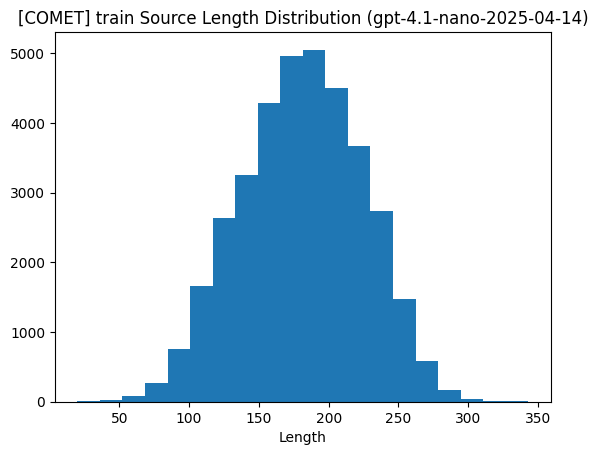

In [167]:
source_lens = [len(x) for x in processed_df['source']]

plt.clf()
plt.hist(source_lens, bins = 20)
plt.title(f'[COMET] {split} Source Length Distribution ({llm_model})')
plt.xlabel('Length')
plt.savefig(f"figs/{llm_model}_{split}_length_dist.png")
# plt.show()

In [168]:
np.array(source_lens).mean(), np.array(source_lens).min()

(181.03852531505638, 20)

In [169]:
row = processed_df.iloc[0]
print(row['character'])
print(row['source'])

Maria
Maria finds a way to express her creativity by painting and sharing her artwork with friends at the local gallery. She feels more confident every time she receives positive feedback. Her passion for art grows stronger with each new piece she creates.


# Format as Instruction Format

In [170]:
from transformers import AutoTokenizer

model_name = "microsoft/phi-4"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [171]:
system_message = '''
You are building an emotion‑prediction component that, given a character name and a brief situational description, must identify the character’s emotional state and the reason for it.

When given an input of the form:
```
Character:  {character}
Source: {source}
```
your job is to:

1. **Map the Emotion:**  
   - Choose among the 8 primary emotions from Plutchik’s Wheel (joy, trust, fear, surprise, sadness, disgust, anger, anticipation).  
   - For each, assign one of: `"na"` (not applicable), `"low"`, `"medium"`, or `"high"`.

2. **Write a Reason:**  
   - Provide a single sentence explaining why the character feels as you’ve labeled.

## Map the Emotion: Map the target emotion onto the 8 primary emotions from Plutchik’s Wheel
* Joy
* Trust
* Fear
* Surprise
* Sadness
* Disgust
* Anger
* Anticipation

For each emotion, assign one of the following intensities:
* "na" (not applicable)
* "low"
* "medium"
* "high"

Interpret the target emotion (e.g., “authoritative”) in terms of Plutchik’s emotions. For example, you might decide:
* trust: high
* joy: low
* anticipation: medium

## Write a Reason:
Provide a one-sentence rationale ("reason") explaining why the subject (if xReact) or the other person (if oReact) feels the given emotion(s).
ex. “She feels empowered and confident after cutting out social media.”


Return in the following JSON format (no extra keys, no explanation outside the JSON)
{
    "emotion": {
        "joy": "na" | "low" | "medium" | "high",
        "trust": "na" | "low" | "medium" | "high",
        "fear": "na" | "low" | "medium" | "high",
        "surprise": "na" | "low" | "medium" | "high",
        "sadness": "na" | "low" | "medium" | "high",
        "disgust": "na" | "low" | "medium" | "high",
        "anger": "na" | "low" | "medium" | "high",
        "anticipation": "na" | "low" | "medium" | "high"
    },
    "reason": "One sentence explaining why these emotions occur"
}
Only return the JSON'''

user_template = '''Source: {source}
Character: {character}'''


In [172]:
# Test Formatting
row = processed_df.iloc[0]

user_message = user_template.format(
    source=row['source'],
    character=row['character']
)

assistant_message = json.dumps(
    {
        "emotion": {
            "joy": row['joy'],
            "trust": row['trust'],
            "fear": row['fear'],
            "surprise": row['surprise'],
            "sadness": row['sadness'],
            "disgust": row['disgust'],
            "anger": row['anger'],
            "anticipation": row['anticipation']
        },
        "reason": row['reason']
    }
)
messages = [
    {"role": "system", "content": system_message},
    {"role": "user", "content": user_message},
    {"role": "assistant", "content": assistant_message}
]
source = tokenizer.apply_chat_template(messages, tokenize = False)

In [173]:
import pprint
pprint.pprint(source)

('<|im_start|>system<|im_sep|>\n'
 'You are building an emotion‑prediction component that, given a character '
 'name and a brief situational description, must identify the character’s '
 'emotional state and the reason for it.\n'
 '\n'
 'When given an input of the form:\n'
 '```\n'
 'Character:  {character}\n'
 'Source: {source}\n'
 '```\n'
 'your job is to:\n'
 '\n'
 '1. **Map the Emotion:**  \n'
 '   - Choose among the 8 primary emotions from Plutchik’s Wheel (joy, trust, '
 'fear, surprise, sadness, disgust, anger, anticipation).  \n'
 '   - For each, assign one of: `"na"` (not applicable), `"low"`, `"medium"`, '
 'or `"high"`.\n'
 '\n'
 '2. **Write a Reason:**  \n'
 '   - Provide a single sentence explaining why the character feels as you’ve '
 'labeled.\n'
 '\n'
 '## Map the Emotion: Map the target emotion onto the 8 primary emotions from '
 'Plutchik’s Wheel\n'
 '* Joy\n'
 '* Trust\n'
 '* Fear\n'
 '* Surprise\n'
 '* Sadness\n'
 '* Disgust\n'
 '* Anger\n'
 '* Anticipation\n'
 '\n